# SOSE HEAT BUDGET

(isel not sel)

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline

/srv/conda/envs/notebook/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
from dask.distributed import Client

client = Client("tcp://10.32.60.236:40135")
client

Client Scheduler: tcp://10.32.60.236:40135 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 6 Cores: 12 Memory: 69.00 GB


In [3]:
ocean_url = 'https://raw.githubusercontent.com/pangeo-data/pangeo-datastore/master/intake-catalogs/ocean.yaml'
ocean_cat = intake.Catalog(ocean_url)
ds = ocean_cat["SOSE"].to_dask()
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

In [4]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

## Heat budget for WG (entire water column)

In [27]:
dsr.Z[0]

<xarray.DataArray 'Z' ()>
array(-5., dtype=float32)
Coordinates:
    Z        float32 -5.0
Attributes:
    axis:           Z
    long_name:      vertical coordinate of cell center
    positive:       down
    standard_name:  depth
    units:          m

In [30]:
sst_mean = dsr.THETA.isel(Z=0).mean(dim='time').load()

In [33]:
surface_mask = (coords.hFacC[0]>0).load()

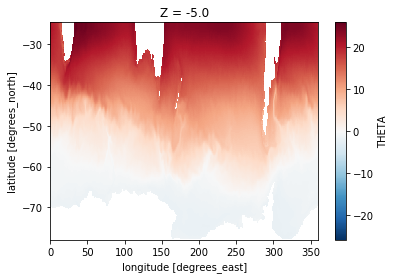

In [34]:
sst_mean.where(surface_mask).plot()

In [44]:
left_lon = 298
upper_lat = -65
right_lon = 360
lower_lat = -78

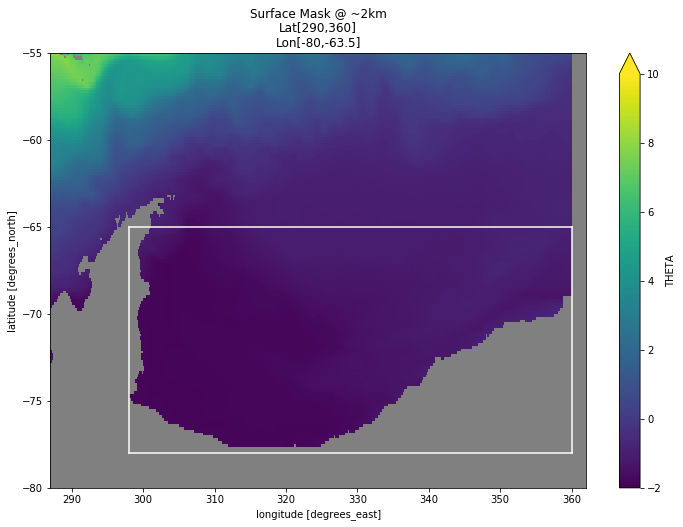

In [45]:
fig, ax = plt.subplots(figsize=(12,8), subplot_kw={'facecolor': '0.5'})
(sst_mean.where(surface_mask)).plot(ax=ax, vmin=-2, vmax=10)
ax.plot([left_lon, right_lon], [upper_lat, upper_lat], color='w')
ax.plot([right_lon, right_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, left_lon], [lower_lat, upper_lat], color='w')
ax.plot([left_lon, right_lon], [lower_lat, lower_lat], color='w')
#ax.patch(xy=(-80, 290), width=70, height=20)
#ax.patch(xy=(295,-80), width = 1, height = 1)
ax.set_xlim([287, 362])
ax.set_ylim([-80, -55])
plt.title('Surface Mask @ ~2km\nLat[290,360]\nLon[-80,-63.5]');

In [77]:
y_lower_lat = 0
y_upper_lat = 78
y_x_left_lon = 1788
y_x_right_lon = 2159

x_left_lon = 1788
x_right_lon = 2159
x_y_upper_lat = 78
x_y_lower_lat = 0

In [78]:
#set the boundaries
y_lat_range = dict(YG=slice(y_lower_lat, y_upper_lat))
y_lon_range = dict(XC=slice(y_x_left_lon, y_x_right_lon))

x_lat_range = dict(YC=slice(x_y_upper_lat, x_y_lower_lat))
x_lon_range = dict(XG=slice(x_left_lon, x_right_lon))

In [8]:
#advective flux
adv_flux_y_lower = dsr.ADVy_TH.isel(**y_lon_range_lower, **y_lat_range_lower, **lower_cell_range_z).diff(
                                                                                  dim='YG').sum(dim='Z').load()
adv_flux_x_lower = dsr.ADVx_TH.isel(**x_lon_range_lower, **x_lat_range_lower, **lower_cell_range_z).diff(
                                                                                  dim='XG').sum(dim='Z').load()
adv_flux_z_lower = dsr.ADVr_TH.isel(**y_lon_range_lower, **x_lat_range_lower, Zl=27).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438, XG: 1, YG: 1)>
array([[[-149.8723 ]],

       [[ -18.50084]],

       ...,

       [[-426.75348]],

       [[-622.4938 ]]], dtype=float32)
Coordinates:
  * XG       (XG) float32 320.1667
    YC       float32 -66.2083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XC       float32 320.08334
  * YG       (YG) float32 -66.12497
    Zl       float32 -1904.0

## Heat budget for Lower WG (-2,046m to bottom)

In [5]:
dsr.Z[27]

<xarray.DataArray 'Z' ()>
array(-2046., dtype=float32)
Coordinates:
    Z        float32 -2046.0
Attributes:
    axis:           Z
    long_name:      vertical coordinate of cell center
    positive:       down
    standard_name:  depth
    units:          m

In [6]:
y_lower = 70
y_upper = 72
y_x_center = 1920

x_left = 1920
x_right = 1922
x_y_center = 70

z = 27, 42

zl1 = 27
zl2 = 42

In [7]:
#set the boundaries
y_lat_range_lower = dict(YG=slice(y_lower, y_upper))
y_lon_range_lower = dict(XC=y_x_center)

x_lat_range_lower = dict(YC=x_y_center)
x_lon_range_lower = dict(XG=slice(x_left, x_right))

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [8]:
#advective flux
adv_flux_y_lower = dsr.ADVy_TH.isel(**y_lon_range_lower, **y_lat_range_lower, **lower_cell_range_z).diff(
                                                                                  dim='YG').sum(dim='Z').load()
adv_flux_x_lower = dsr.ADVx_TH.isel(**x_lon_range_lower, **x_lat_range_lower, **lower_cell_range_z).diff(
                                                                                  dim='XG').sum(dim='Z').load()
adv_flux_z_lower = dsr.ADVr_TH.isel(**y_lon_range_lower, **x_lat_range_lower, Zl=27).load()

adv_flux_lower = adv_flux_x_lower + adv_flux_y_lower + adv_flux_z_lower
adv_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438, XG: 1, YG: 1)>
array([[[-149.8723 ]],

       [[ -18.50084]],

       ...,

       [[-426.75348]],

       [[-622.4938 ]]], dtype=float32)
Coordinates:
  * XG       (XG) float32 320.1667
    YC       float32 -66.2083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XC       float32 320.08334
  * YG       (YG) float32 -66.12497
    Zl       float32 -1904.0

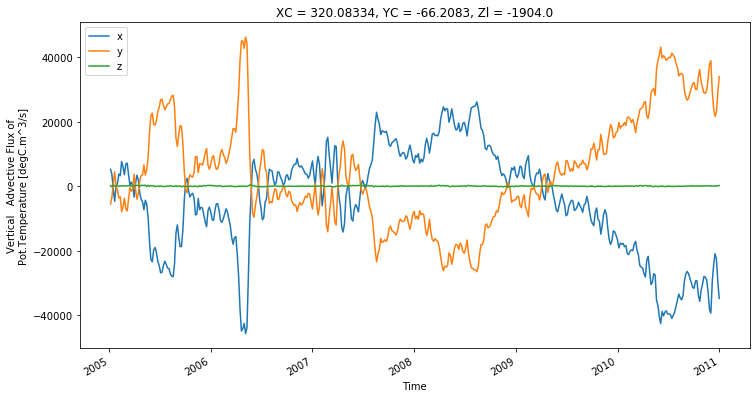

In [9]:
plt.figure(figsize=(12,6))

adv_flux_x_lower.plot(label='x')
adv_flux_y_lower.plot(label='y')
adv_flux_z_lower.plot(label='z')
plt.legend()

In [10]:
#diffusive flux
diff_flux_y_lower = dsr.DFyE_TH.isel(**y_lon_range_lower, **y_lat_range_lower, **lower_cell_range_z).diff(
                                                                                  dim='YG').sum(dim='Z').load()
diff_flux_x_lower = dsr.DFxE_TH.isel(**x_lon_range_lower, **x_lat_range_lower, **lower_cell_range_z).diff(
                                                                                  dim='XG').sum(dim='Z').load()
diff_flux_z_lower =  - (dsr.DFrE_TH.isel(**y_lon_range_lower, **x_lat_range_lower, Zl=27).load()
                     + dsr.DFrI_TH.isel(**y_lon_range_lower, **x_lat_range_lower, Zl=27).load()
                     + dsr.KPPg_TH.isel(**y_lon_range_lower, **x_lat_range_lower, Zl=27).load())

diff_flux_lower = diff_flux_x_lower + diff_flux_y_lower + diff_flux_z_lower
diff_flux_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438, XG: 1, YG: 1)>
array([[[  -0.551062]],

       [[  -2.523781]],

       ...,

       [[-334.49133 ]],

       [[-309.32837 ]]], dtype=float32)
Coordinates:
  * XG       (XG) float32 320.1667
    YC       float32 -66.2083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XC       float32 320.08334
  * YG       (YG) float32 -66.12497
    Zl       float32 -1904.0

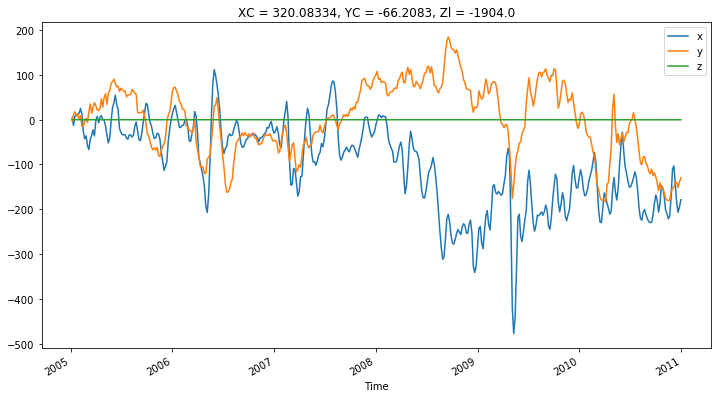

In [11]:
plt.figure(figsize=(12,6))
diff_flux_x_lower.plot(label='x')
diff_flux_y_lower.plot(label='y')
diff_flux_z_lower.plot(label='z')
plt.legend()

In [12]:
tottend_weddell_lower = ((dsr.TOTTTEND * coords.rA * coords.drF * coords.hFacC).isel(
                         **y_lon_range_lower, **x_lat_range_lower, **lower_cell_range_z).sum(
                                                                            dim=['Z']))/ (24*60*60)
tottend_weddell_lower.load()
#units: (˚C m^3)/s

<xarray.DataArray (time: 438)>
array([ 150.422975,   21.024919,  185.743426, ..., -103.479329,  761.243333,
        931.819815])
Coordinates:
    XC       float32 320.08334
    YC       float32 -66.2083
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

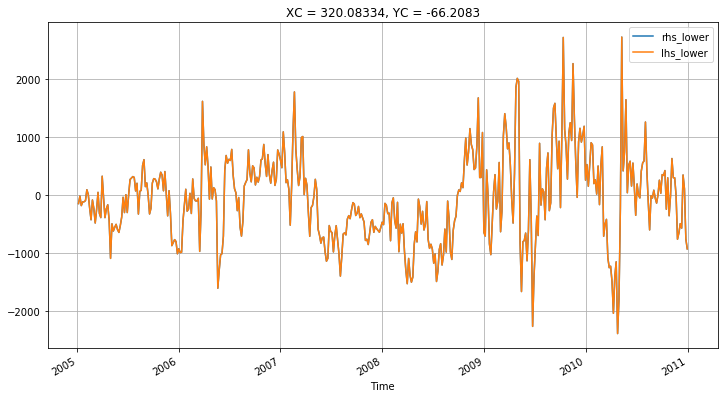

In [13]:
plt.figure(figsize=(12,6))
rhs_lower = adv_flux_lower + diff_flux_lower
lhs_lower =  - tottend_weddell_lower
rhs_lower.plot(label='rhs_lower')
lhs_lower.plot(label='lhs_lower')
plt.legend()
plt.grid();
# tried dividing by 24 (too big), then 24*60 (still too big but better), then 24*60*60 but then it's 0. 

In [14]:
all_terms_lower = xr.merge([adv_flux_lower.rename('adv_flux'), 
                            diff_flux_lower.rename('diff_flux'),
                            tottend_weddell_lower.rename('tottend')])
all_terms_lower

<xarray.Dataset>
Dimensions:    (XG: 1, YG: 1, time: 438)
Coordinates:
  * XG         (XG) float32 320.1667
    YC         float32 -66.2083
  * time       (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    XC         float32 320.08334
  * YG         (YG) float32 -66.12497
    Zl         float32 -1904.0
Data variables:
    adv_flux   (time, XG, YG) float32 -149.8723 -18.50084 ... -622.4938
    diff_flux  (time, XG, YG) float32 -0.55106235 -2.523781 ... -309.32837
    tottend    (time) float64 150.4 21.02 185.7 121.2 ... -103.5 761.2 931.8

In [15]:
df_lower = all_terms_lower.mean(dim='time').reset_coords(drop=True).to_array().to_dataframe(name='budget')
df_lower

,,,budget
variable,XG,YG,
adv_flux,320.166687,-66.124969,30.709200
diff_flux,320.166687,-66.124969,-102.440353
tottend,320.166687,-66.124969,71.731288


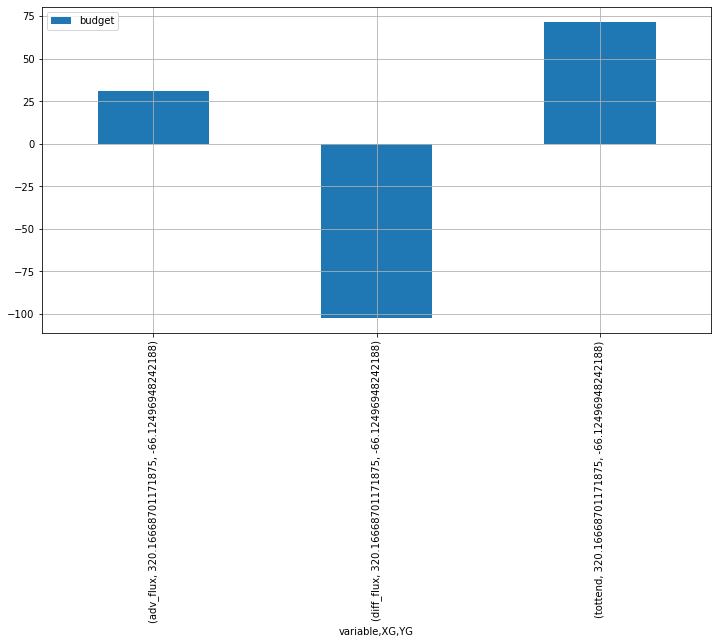

In [16]:
df_lower.plot(figsize=(12,6), kind='bar')
plt.grid()

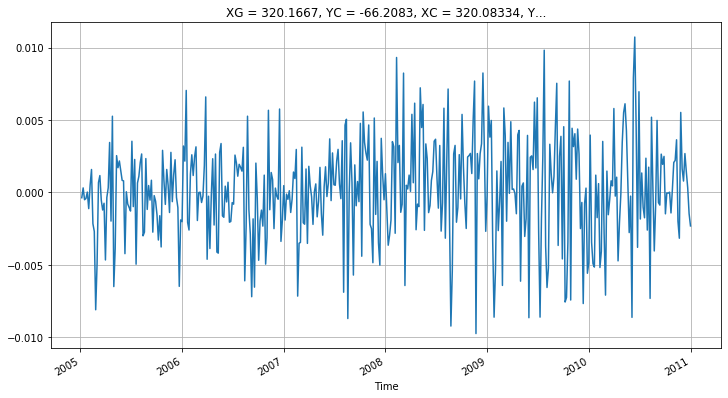

In [26]:
(rhs_lower - lhs_lower).plot(figsize=(12,6))
plt.grid();